In [41]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [42]:
# Configuration
data_dir = '../../dataset/train-curat-dataset'

In [43]:
model_name = 'mobilenet_v2' 
num_classes = 7
batch_size = 16
num_epochs = 200
feature_extract = True
 
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [44]:
# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
# Create training and validation dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [46]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    val_loss_history = []
    train_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history, train_loss_history, val_loss_history


In [47]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [48]:
 #initilize the mobilenet-v2 model
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0
 
    if model_name == "mobilenet_v2":
        """ mobilenet-v2
        """
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[-1].in_features
        model_ft.classifier[-1] = nn.Linear(num_ftrs, num_classes)
        input_size = 224
 
    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [49]:
# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
 
# Print the model architecture
#print(model_ft)

# Send the model to GPU
model_ft = model_ft.to(device)

In [50]:
'''
Gather the parameters to be optimized/updated in this run. If we are
fine-tuning we will be updating all parameters. However, if we are
doing feature extract method, we will only update the parameters
that we have just initialized, i.e. the parameters with requires_grad
is True
'''
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t", name)
else:
    for name, param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t", name)
 
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
 
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [51]:
# Plot training and validation accuracy and loss
def plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs):
    epochs = range(1, num_epochs + 1)

    plt.figure(figsize=(14, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc_hist, label='Training Accuracy')
    plt.plot(epochs, val_acc_hist, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss_hist, label='Training Loss')
    plt.plot(epochs, val_loss_hist, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


In [52]:
###
# Train and evaluate
model_ft, train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist = train_model(model_ft, dataloaders, criterion, optimizer_ft, num_epochs=num_epochs)
 

Epoch 0/199
----------
train Loss: 1.4798 Acc: 0.4752
val Loss: 1.0865 Acc: 0.6545
Epoch 1/199
----------
train Loss: 1.0705 Acc: 0.6462
val Loss: 0.8101 Acc: 0.7730
Epoch 2/199
----------
train Loss: 0.9170 Acc: 0.6903
val Loss: 0.7310 Acc: 0.7881
Epoch 3/199
----------
train Loss: 0.8374 Acc: 0.7223
val Loss: 0.6412 Acc: 0.8197
Epoch 4/199
----------
train Loss: 0.7851 Acc: 0.7353
val Loss: 0.6350 Acc: 0.7945
Epoch 5/199
----------
train Loss: 0.7334 Acc: 0.7630
val Loss: 0.5799 Acc: 0.8184
Epoch 6/199
----------
train Loss: 0.7039 Acc: 0.7605
val Loss: 0.6041 Acc: 0.8045
Epoch 7/199
----------
train Loss: 0.6986 Acc: 0.7592
val Loss: 0.5822 Acc: 0.8121
Epoch 8/199
----------
train Loss: 0.6995 Acc: 0.7597
val Loss: 0.5486 Acc: 0.8361
Epoch 9/199
----------
train Loss: 0.6535 Acc: 0.7777
val Loss: 0.5629 Acc: 0.8285
Epoch 10/199
----------
train Loss: 0.6592 Acc: 0.7803
val Loss: 0.5319 Acc: 0.8323
Epoch 11/199
----------
train Loss: 0.6498 Acc: 0.7735
val Loss: 0.5312 Acc: 0.8398
Ep

In [53]:
# Save the best model weights
torch.save(model_ft.state_dict(), 'building_orig_mobilenet_weights.pth')

In [54]:
train_acc_hist = torch.tensor(train_acc_hist)
val_acc_hist = torch.tensor(val_acc_hist)
train_loss_hist = torch.tensor(train_loss_hist)
val_loss_hist = torch.tensor(val_loss_hist)

train_acc_hist = train_acc_hist.cpu()
val_acc_hist = val_acc_hist.cpu()
train_loss_hist = train_loss_hist.cpu()
val_loss_hist = val_loss_hist.cpu()

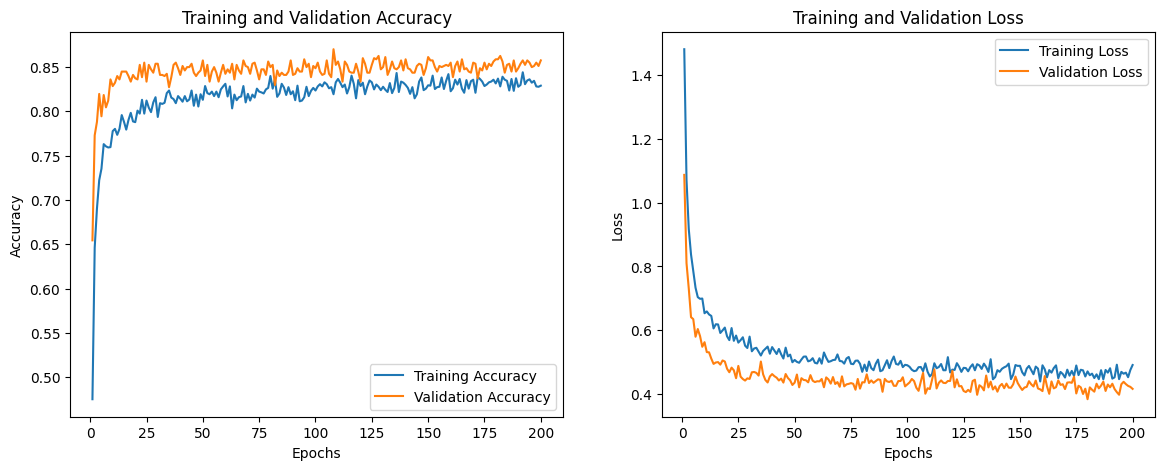

In [55]:
# Plot training and validation accuracy and loss
plot_training_history(train_acc_hist, val_acc_hist, train_loss_hist, val_loss_hist, num_epochs)


In [61]:
# Evaluate the model on test data
model_ft.eval()
test_corrects = 0
all_preds = []
all_labels = []
 
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
 
    outputs = model_ft(inputs)
    _, preds = torch.max(outputs, 1)
 
    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())
    test_corrects += torch.sum(preds == labels.data)
 
test_acc = test_corrects.double() / dataset_sizes['test']
print('Test Accuracy: {:.4f}'.format(test_acc))
 
# Generate confusion matrix and classification report
conf_mat = confusion_matrix(all_labels, all_preds)
class_report = classification_report(all_labels, all_preds, target_names=class_names)
print("Confusion Matrix:\n", conf_mat)
print("Classification Report:\n", class_report)

Test Accuracy: 0.8422
Confusion Matrix:
 [[103   2   2   2   1   5   9]
 [  0  95  14   0   2   3   2]
 [  0   8 113   0   2   0   1]
 [  2   5   4  77   1   4  11]
 [  0   1   0   0 117   1   1]
 [  4   3   3   3   1  76  10]
 [  1   2   3   2   7   3  86]]
Classification Report:
               precision    recall  f1-score   support

       algae       0.94      0.83      0.88       124
 major_crack       0.82      0.82      0.82       116
 minor_crack       0.81      0.91      0.86       124
     peeling       0.92      0.74      0.82       104
       plain       0.89      0.97      0.93       120
    spalling       0.83      0.76      0.79       100
       stain       0.72      0.83      0.77       104

    accuracy                           0.84       792
   macro avg       0.85      0.84      0.84       792
weighted avg       0.85      0.84      0.84       792



In [63]:
import pandas as pd

# Convert the labels and predictions to their corresponding class names
actual_class_names = [class_names[label] for label in all_labels]
predicted_class_names = [class_names[pred] for pred in all_preds]

# Create the DataFrame
res = pd.DataFrame({"actual": actual_class_names, "predicted": predicted_class_names})

#res = pd.DataFrame( {"actual": all_labels, "predicted": all_preds})
print(res)
res.to_csv('mobil_curat_results.csv', index=False)

          actual    predicted
0       spalling     spalling
1          algae        algae
2          stain        stain
3    minor_crack  minor_crack
4       spalling     spalling
..           ...          ...
787  major_crack  major_crack
788        algae        algae
789  minor_crack  minor_crack
790     spalling     spalling
791        algae        algae

[792 rows x 2 columns]


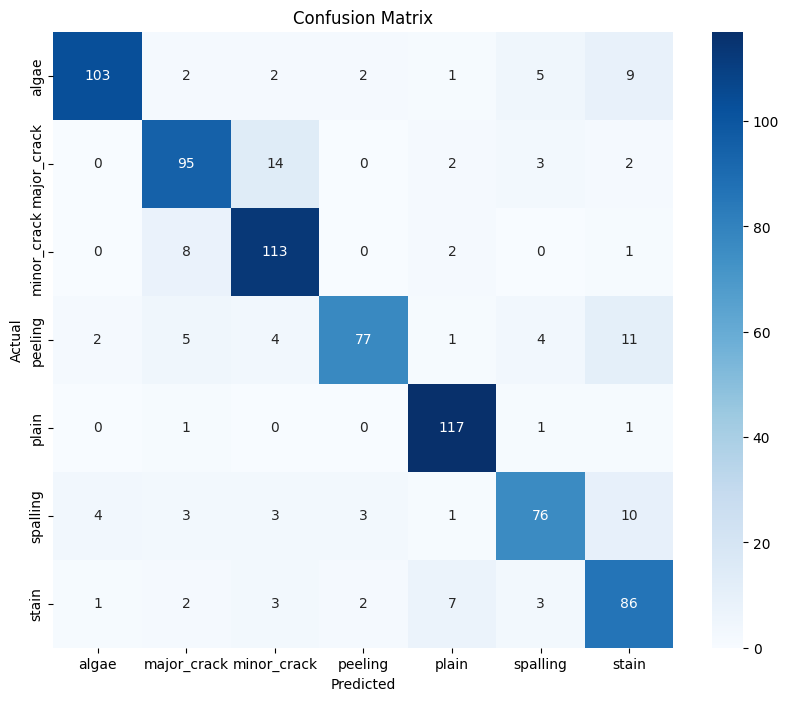

In [59]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.savefig('building_orig_mobilenet_confusion_matrix.png')
plt.show()
 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.5179958].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.2391288].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5253019..1.1236603].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.91917115..0.51363856].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02868402..1.1062311].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.6555357..0.74021804].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117

Accuracy: 0.8422
Average Precision: 0.8458
Average Recall: 0.8376
Average F1-Score: 0.8385


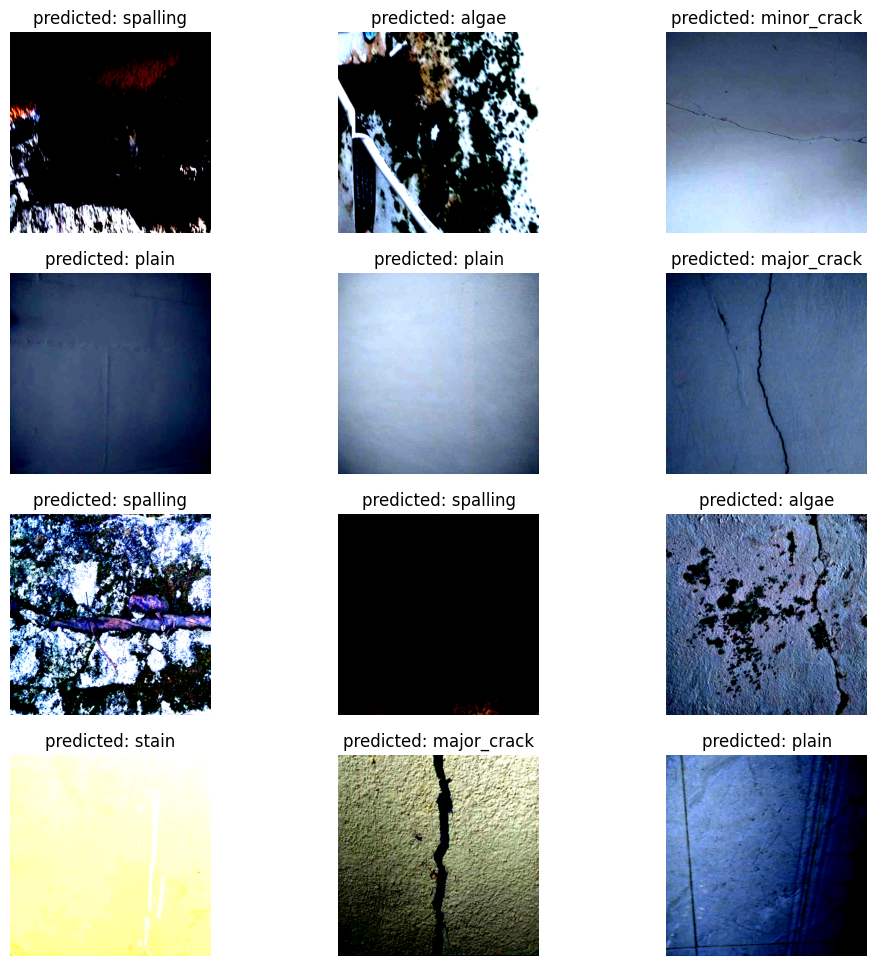

In [62]:
def visualize_model(model, dataloaders, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(12, 12))  # Increase the figure size
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(4, 3, images_so_far)  # Create a 3x3 grid of subplots
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                plt.imshow(inputs.cpu().data[j].numpy().transpose((1, 2, 0)))
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    
    model.train(mode=was_training)


# Visualize some predictions
visualize_model(model_ft, dataloaders)
 
# Compute and display evaluation metrics
y_true = np.array(all_labels)
y_pred = np.array(all_preds)
 
accuracy = np.mean(y_true == y_pred)
precision = np.diag(conf_mat) / np.sum(conf_mat, axis=0)
recall = np.diag(conf_mat) / np.sum(conf_mat, axis=1)
f1_score = 2 * precision * recall / (precision + recall)
 
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print the average precision, recall, and F1-score
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-Score: {avg_f1_score:.4f}")
 
# Ensure the confusion matrix and the classification report are saved
with open('orig_mobilenet_classification_report.txt', 'w') as f:
    f.write(f"Classification Report:\n{class_report}\n")